# Main Simulation Notebook

Run the same simulation flow as main.py and edit configuration directly in this notebook without changing the base config.yaml file.


In [6]:
import copy
import sys
from pathlib import Path

import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

PROJECT_ROOT = Path.cwd()
if not (PROJECT_ROOT / 'src').exists():
    PROJECT_ROOT = PROJECT_ROOT.parent
if not (PROJECT_ROOT / 'src').exists():
    raise RuntimeError("Cannot find project root containing 'src' directory")
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from src.oracle.oracle import OracleModule, OracleConfig
from src.lp.lp import LPModule, LPConfig
from src.perp.perp import PerpModule, PerpConfig
from src.strategy.strategy import StrategyModule, StrategyConfig
from src.portfolio.portfolio import PortfolioModule, TransactionType
from src.engine.backtest_engine import BacktestEngine

CONFIG_PATH = PROJECT_ROOT / 'config.yaml'


In [7]:
def load_base_config(path: Path = CONFIG_PATH) -> dict:
    with open(path, "r", encoding="utf-8") as f:
        return yaml.safe_load(f)

def deep_update(base: dict, updates: dict) -> dict:
    for key, value in updates.items():
        if isinstance(value, dict) and isinstance(base.get(key), dict):
            deep_update(base[key], value)
        else:
            base[key] = value
    return base

# Edit parameters here
overrides = {
    "capital": {
        "lp_capital": 10000.0,
        "perp_capital": 5000.0,
        "leverage": 5.0,
    },
    "market": {
        "start_price": 2000.0,
        "days_to_run": 180,
        "annual_volatility": 0.70,
        "seed": 42,
    },
    "lp": {
        "base_apr": 0.04,
        "range_width": 0.065,
        "rebalance_threshold": 0.25,
    },
    "strategy": {
        "hedge_mode": "always",
        "use_safety_net": True,
        "safety_net_pct": 0.10,
        "hedge_threshold": 0.10,
        "ema_period": 200,
    },
    "costs": {
        "gas_fee_usd": 2.0,
        "slippage": 0.001,
        "perp_taker_fee": 0.0005,
        "funding_rate_8h": 0.0001,
    },
    "execution": {
        "interval_minutes": 5,
    },
    "harvesting": {
        "enabled": False,
        "withdrawal_freq_days": 30,
        "target_amount": 500.0,
    },
    "capital_management": {
        "enabled": True,
        "freq_days": 15,
    },
}

cfg = deep_update(copy.deepcopy(load_base_config()), overrides)
cfg


{'capital': {'lp_capital': 10000.0, 'perp_capital': 5000.0, 'leverage': 5.0},
 'market': {'start_price': 2000.0,
  'days_to_run': 180,
  'annual_volatility': 0.7,
  'seed': 42},
 'lp': {'base_apr': 0.04, 'range_width': 0.065, 'rebalance_threshold': 0.25},
 'strategy': {'hedge_mode': 'always',
  'use_safety_net': True,
  'safety_net_pct': 0.1,
  'hedge_threshold': 0.1,
  'ema_period': 200},
 'costs': {'gas_fee_usd': 2.0,
  'slippage': 0.001,
  'perp_taker_fee': 0.0005,
  'funding_rate_8h': 0.0001},
 'harvesting': {'enabled': False,
  'withdrawal_freq_days': 30,
  'target_amount': 500.0},
 'optimization_space': {'range_width': [True, 0.05, 0.1, 0.02],
  'rebalance_threshold': [True, 0.1, 0.3, 0.05],
  'hedge_threshold': [True, 0.1, 0.25, 0.05],
  'safety_net_pct': [False, 0.02, 0.1, 0.02],
  'annual_volatility': [False, 0.4, 0.8, 0.2],
  'seed': [True, 42, 72, 1],
  'freq_da': [True, 5, 30, 15]},
 'execution': {'interval_minutes': 5},
 'capital_management': {'enabled': True, 'freq_days':

In [8]:
def run_simulation(cfg: dict, show_plot: bool = True):
    lp_capital = float(cfg["capital"]["lp_capital"])
    perp_capital = float(cfg["capital"]["perp_capital"])
    total_capital = lp_capital + perp_capital
    leverage = float(cfg["capital"]["leverage"])
    days_to_run = int(cfg["market"]["days_to_run"])
    funding_rate_8h = float(cfg["costs"]["funding_rate_8h"])

    seed_val = cfg["market"]["seed"]
    seed_val = int(seed_val) if seed_val not in ["null", None, "None", ""] else None

    oracle_cfg = OracleConfig(
        start_price=float(cfg["market"]["start_price"]),
        days=days_to_run,
        annual_volatility=float(cfg["market"]["annual_volatility"]),
        seed=seed_val,
        timeframe="5m",
    )
    lp_cfg = LPConfig(
        initial_capital=lp_capital,
        range_width=float(cfg["lp"]["range_width"]),
        rebalance_threshold=float(cfg["lp"]["rebalance_threshold"]),
        fee_mode="base_apr",
        base_apr=float(cfg["lp"]["base_apr"]),
        gas_fee=float(cfg["costs"]["gas_fee_usd"]),
        slippage=float(cfg["costs"]["slippage"]),
    )
    strat_cfg = StrategyConfig(
        hedge_mode=cfg["strategy"]["hedge_mode"],
        use_safety_net=bool(cfg["strategy"]["use_safety_net"]),
        safety_net_pct=float(cfg["strategy"]["safety_net_pct"]),
        hedge_threshold=float(cfg["strategy"]["hedge_threshold"]),
        ema_period=int(cfg["strategy"]["ema_period"]),
    )
    perp_cfg = PerpConfig(leverage=leverage, taker_fee=float(cfg["costs"]["perp_taker_fee"]))

    oracle = OracleModule()
    lp = LPModule(lp_cfg, oracle_cfg.start_price)
    perp = PerpModule(perp_cfg)
    strategy = StrategyModule(lp, perp)
    portfolio = PortfolioModule(total_capital)
    portfolio.allocate_to_lp(lp_capital)

    engine = BacktestEngine(oracle, lp, perp, strategy, portfolio)
    data = oracle.generate_data(oracle_cfg)

    results = engine.run(
        data,
        strat_cfg,
        funding_rate=funding_rate_8h,
        harvest_config=cfg.get("harvesting", {}),
        cross_rebalance_config=cfg.get("capital_management", {"enabled": True, "freq_days": 30}),
        execution_interval_min=int(cfg.get("execution", {}).get("interval_minutes", 1)),
    )
    results["price"] = data["close"].values

    wealth_series = results["net_equity"] + results["total_withdrawn"]
    roll_max = wealth_series.cummax()
    drawdown = (wealth_series - roll_max) / roll_max
    max_drawdown = drawdown.min() * 100

    initial_equity = total_capital
    final_equity = results["net_equity"].iloc[-1]
    total_withdrawn = results["total_withdrawn"].iloc[-1]
    total_wealth = final_equity + total_withdrawn
    net_profit = total_wealth - initial_equity
    total_roi = net_profit / initial_equity
    cagr = (pow(1 + total_roi, 365 / days_to_run) - 1) * 100

    summary = pd.DataFrame([
        {"metric": "Initial Capital", "value": initial_equity},
        {"metric": "Final Net Equity", "value": final_equity},
        {"metric": "Total Withdrawn", "value": total_withdrawn},
        {"metric": "Total Wealth", "value": total_wealth},
        {"metric": "Net Profit", "value": net_profit},
        {"metric": "CAGR (%)", "value": cagr},
        {"metric": "Max Drawdown (%)", "value": max_drawdown},
        {"metric": "LP Rebalances", "value": lp.rebalance_count},
        {"metric": "Hedge Trades", "value": engine.hedge_count},
        {"metric": "Margin Call Count", "value": len(engine.margin_call_events)},
    ])

    if show_plot:
        fig, ax = plt.subplots(figsize=(12, 5))
        ax.plot(results.index, results["net_equity"], label="Net Equity")
        ax.plot(results.index, wealth_series, label="Total Wealth", linestyle="--")
        ax.set_title("Simulation Equity Curve")
        ax.set_xlabel("Tick")
        ax.set_ylabel("USD")
        ax.grid(alpha=0.3)
        ax.legend()
        plt.tight_layout()
        plt.show()

    return results, summary


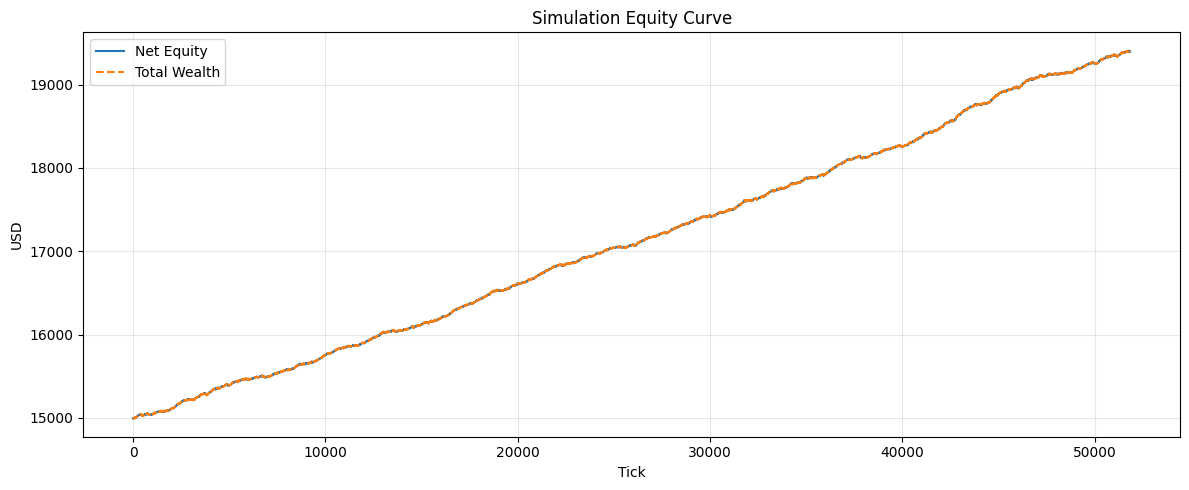

,metric,value
0,Initial Capital,15000.000000
1,Final Net Equity,19399.414490
2,Total Withdrawn,0.000000
3,Total Wealth,19399.414490
4,Net Profit,4399.414490
5,CAGR (%),68.460246
6,Max Drawdown (%),-0.166118
7,LP Rebalances,225.000000
8,Hedge Trades,4832.000000
9,Margin Call Count,0.000000


In [9]:
results, summary = run_simulation(cfg, show_plot=True)
summary

In [10]:
# Preview the last rows of per-tick results
results.tail()


,timestamp,net_equity,cex_wallet_balance,cex_available_margin,lp_value,perp_pnl,total_fees_collected,total_costs,total_withdrawn,event,price,perp_size,lp_eth
51836,2026-02-26 11:40:00,19402.434862,5693.355238,4178.570816,13663.919046,45.160577,7140.990683,2886.506676,0.0,,1721.056206,4.505701,4.191414
51837,2026-02-26 11:45:00,19401.177724,5695.897282,4313.973480,13678.008135,27.272307,7141.153219,2886.882089,0.0,HEDGE_DEC(Threshold Drift),1724.378844,4.070282,4.070282
51838,2026-02-26 11:50:00,19401.339807,5695.897282,4352.339838,13639.803859,65.638665,7141.315302,2886.882089,0.0,,1714.952873,4.070282,4.415082
51839,2026-02-26 11:55:00,19401.507030,5695.897282,4352.279192,13640.031729,65.578019,7141.477388,2886.882089,0.0,,1714.967773,4.070282,4.414589
51840,2026-02-26 12:00:00,19399.414490,6371.515858,4848.250549,12932.409775,95.488858,7141.639090,2887.405984,0.0,HEDGE_INC(Threshold Drift)|SWEEP_LP_TO_CEX($67...,1707.619182,4.683879,4.451422
